# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay


# Upload and Read Data

In [2]:
df = pd.read_csv('/content/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocessing

In [5]:
# Show missing values
print("Missing values before handling:\n", df.isnull().sum())


Missing values before handling:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
# Fill missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Confirm missing values handled
print("Missing values after handling:\n", df.isnull().sum())

Missing values after handling:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [7]:
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)



Duplicate rows: 0


In [8]:
# Drop non-numeric and unnecessary columns
df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

In [9]:
# Encode categorical columns
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

In [10]:
# 1. FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 2. IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)


# 6. Age Binning
df['Age'] = df['Age'].fillna(df['Age'].median())
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,18,40,60,100],
                      labels=['Child','Teen','Adult','MidAge','Senior'])

# 7. Fare Binning
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low','Mid','High','VeryHigh'])

# ---------------- Encoding Categorical Features ----------------
label_enc = LabelEncoder()
for col in ['AgeBin','FareBin']:
    df[col] = label_enc.fit_transform(df[col].astype(str))

# ---------------- Final Feature Selection ----------------
available_features = [
    'Pclass','Sex','Age','AgeBin','Fare','FareBin',
    'Embarked_Q','Embarked_S',
    'FamilySize','IsAlone'
]

target = 'Survived'

final_df = df[available_features + [target]]

# Heat map

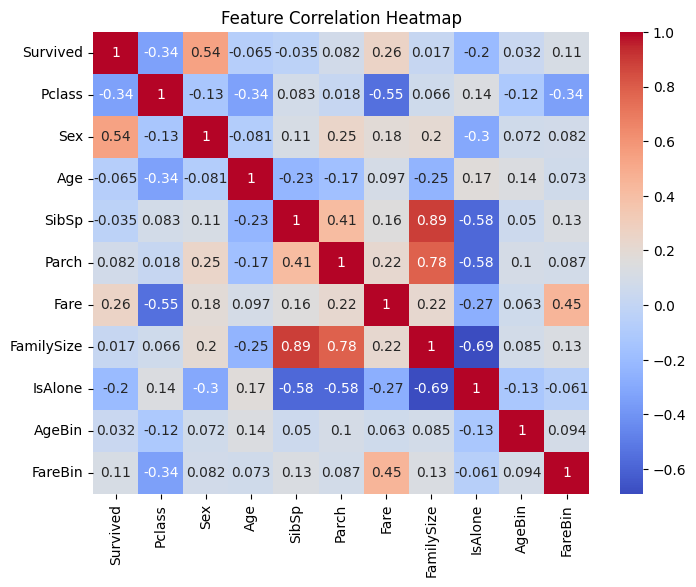

In [11]:
numeric_df = df.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Split data and scalling

In [12]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [13]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
scaler = StandardScaler()
X_train[["Age","Fare","FamilySize"]] = scaler.fit_transform(X_train[["Age","Fare","FamilySize"]])
X_test[["Age","Fare","FamilySize"]] = scaler.transform(X_test[["Age","Fare","FamilySize"]])


# LogisticRegression

In [15]:
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [16]:
# Train Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg_model.predict(X_train)
y_test_pred = log_reg_model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print("Train Accuracy:", round(train_acc, 4))
print("Test Accuracy:", round(test_acc, 4))

Train Accuracy: 0.8006
Test Accuracy: 0.7989


In [17]:
print("Logistic Regression:")
print("F1 Score:", round(f1_score(y_test, y_test_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:,1]), 4))


Logistic Regression:
F1 Score: 0.75
ROC AUC: 0.8844


# Random forest

In [18]:
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=5,             # Limit tree depth
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=3,      # Minimum samples in a leaf node
    max_features='sqrt',     # Limit features considered at each split
    random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [19]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)


In [20]:
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print("Random Forest:")
print("Train Accuracy:", round(train_acc_rf, 4))
print("Test Accuracy:", round(test_acc_rf, 4))

Random Forest:
Train Accuracy: 0.861
Test Accuracy: 0.8101


In [21]:
print("Random Forest:")
print("F1 Score:", round(f1_score(y_test, y_test_pred_rf), 4))
print("ROC AUC:", round(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]), 4))
print("-"*30)


Random Forest:
F1 Score: 0.7463
ROC AUC: 0.8927
------------------------------


# XGBoost

In [22]:

xgb_model = XGBClassifier(
    n_estimators=200,         # More trees
    max_depth=3,              # Limit tree depth
    learning_rate=0.05,       # Slower learning
    subsample=0.8,            # Fraction of rows per tree
    colsample_bytree=0.8,     # Fraction of features per tree
    reg_alpha=0.1,            # L1 regularization
    reg_lambda=1,             # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:01:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

In [24]:
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print("XGBoost:")
print("Train Accuracy:", round(train_acc_xgb, 4))
print("Test Accuracy:", round(test_acc_xgb, 4))

XGBoost:
Train Accuracy: 0.889
Test Accuracy: 0.8212


In [25]:
print("XGBoost:")
print("F1 Score:", round(f1_score(y_test, y_test_pred_xgb), 4))
print("ROC AUC:", round(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]), 4))
print("-"*30)

XGBoost:
F1 Score: 0.7647
ROC AUC: 0.8878
------------------------------


# ROC Curves

<Figure size 800x600 with 0 Axes>

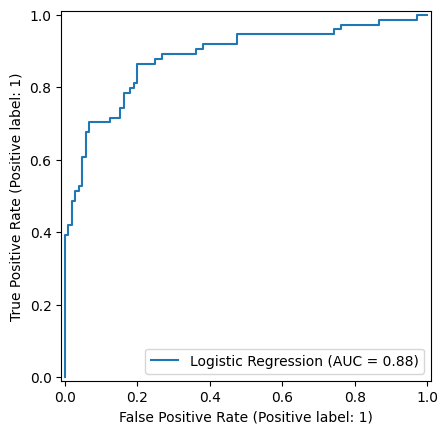

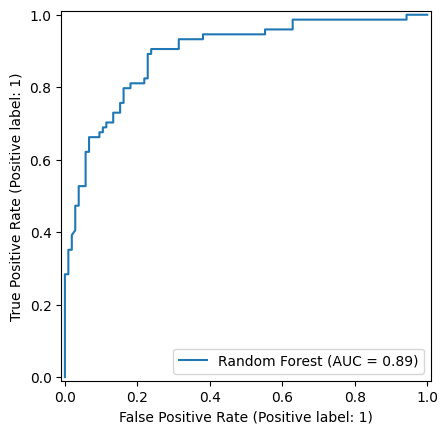

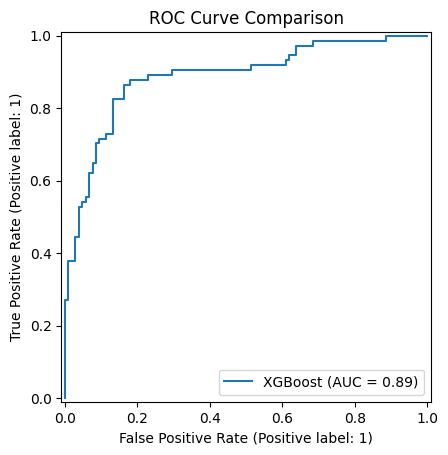

In [27]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))

RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, name="XGBoost")

plt.title("ROC Curve Comparison")
plt.show()


# Summary Table

In [28]:

summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Train Accuracy": [train_acc, train_acc_rf, train_acc_xgb],
    "Test Accuracy": [test_acc, test_acc_rf, test_acc_xgb],
    "F1 Score": [f1_score(y_test, y_test_pred), f1_score(y_test, y_test_pred_rf), f1_score(y_test, y_test_pred_xgb)],
    "ROC AUC": [roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:,1]),
                roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]),
                roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])]
})

print(summary)


                 Model  Train Accuracy  Test Accuracy  F1 Score   ROC AUC
0  Logistic Regression        0.800562       0.798883  0.750000  0.884427
1        Random Forest        0.860955       0.810056  0.746269  0.892728
2              XGBoost        0.889045       0.821229  0.764706  0.887773


# Visualizations

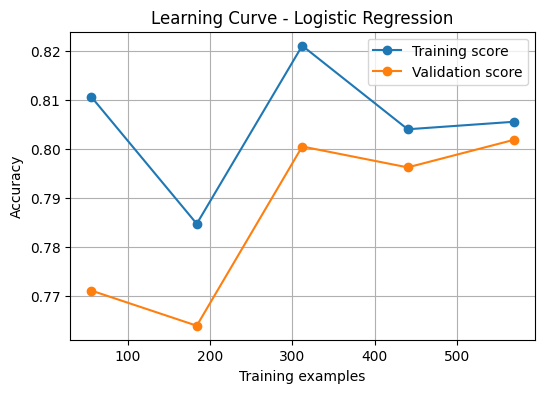

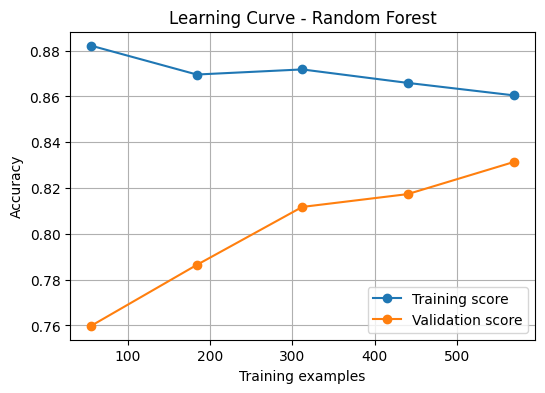

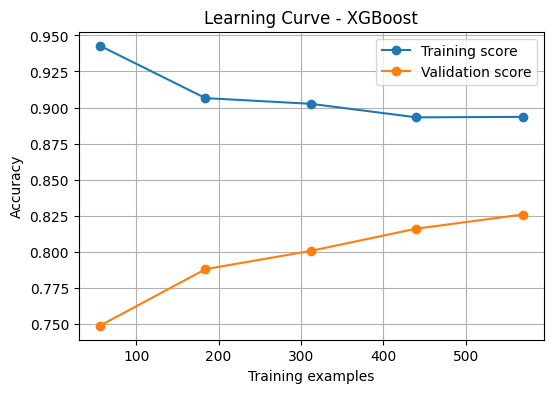

In [29]:


def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curves for each model
plot_learning_curve(log_reg_model, X_train, y_train, "Learning Curve - Logistic Regression")
plot_learning_curve(rf_model, X_train, y_train, "Learning Curve - Random Forest")
plot_learning_curve(xgb_model, X_train, y_train, "Learning Curve - XGBoost")


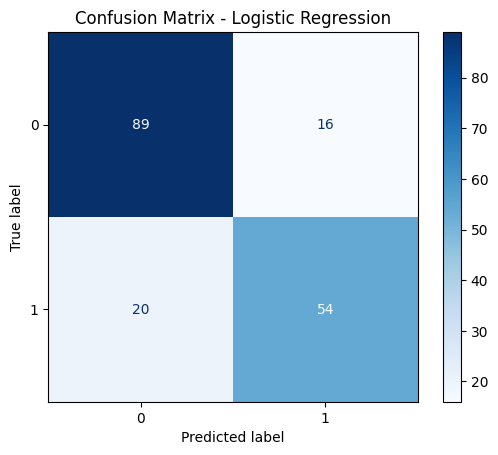

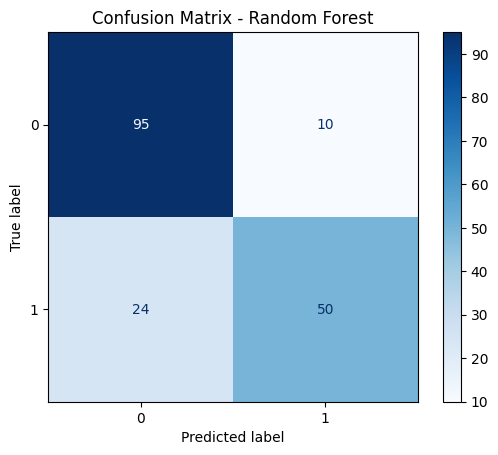

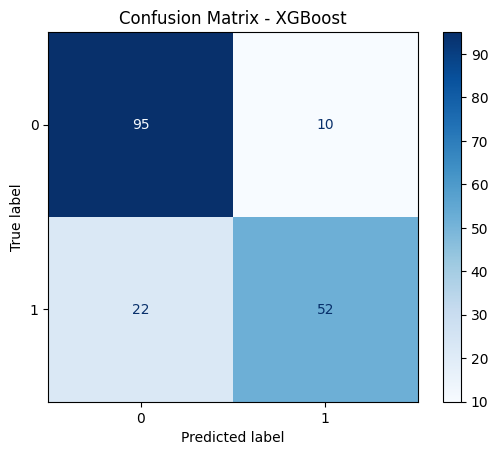

In [30]:


models = {
    "Logistic Regression": log_reg_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

# Plot confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        cmap="Blues",
        values_format="d"
    )
    disp.ax_.set_title(f"Confusion Matrix - {name}")
    plt.show()